Предсказание результатов баскетбольных матчей

In [1]:
import numpy as np
import gdown
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten,
                                     Activation, Input, concatenate, SimpleRNN, GRU, LSTM, Bidirectional, Conv1D,
                                     MaxPooling1D, GlobalMaxPooling1D)
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [2]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)
df = pd.read_csv('basketball.csv', encoding= 'cp1251', sep=';', header=0, index_col=0)
display(df.info(), df.loc[100:104])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52450 entries, 0 to 68314
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TOTAL         52450 non-null  object 
 1   info          52450 non-null  object 
 2   Ком. 1        52450 non-null  int64  
 3   Ком. 2        52450 non-null  float64
 4   Минута        52450 non-null  int64  
 5   Общая минута  52450 non-null  float64
 6   Секунда       52450 non-null  int64  
 7   fcount        52450 non-null  int64  
 8   ftime         52450 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 4.0+ MB


None

,TOTAL,info,Ком. 1,Ком. 2,Минута,Общая минута,Секунда,fcount,ftime
100,0,4081445 Новая Зеландия. Женщины. WBC. Регулярн...,42,39.0,9,39.0,45,81,2385.0
101,"166,5",4082093 Аргентина. Мужчины. LNB(Либертад - Инс...,5,3.0,1,1.0,0,158,60.0
102,"166,5",4082093 Аргентина. Мужчины. LNB(Либертад - Инс...,7,3.0,1,1.0,30,158,90.0
103,"167,5",4082093 Аргентина. Мужчины. LNB(Либертад - Инс...,7,5.0,1,1.0,45,158,105.0
104,"166,5",4082093 Аргентина. Мужчины. LNB(Либертад - Инс...,7,5.0,2,2.0,0,158,120.0


In [3]:
df.describe().loc[['min', '50%', 'mean', 'max']]

,Ком. 1,Ком. 2,Минута,Общая минута,Секунда,fcount,ftime
min,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,5.000000
50%,40.000000,37.000000,5.000000,21.000000,30.00000,152.000000,1290.000000
mean,40.899905,38.687893,4.853651,20.840877,22.99857,151.625815,1273.451192
max,139.000000,134.000000,12.000000,55.000000,55.00000,273.000000,3300.000000


In [4]:
def create_data(df_basketball, maxWordsCount = 3000):
    # Дополнительный столбец - Всего секунд
    df['Секунды'] = df['Минута'] * 60 + df['Секунда']

    xTrain_kom = np.array(df[['Ком. 1','Ком. 2']])
    xTrain_time = np.array(df[['Секунды', 'Минута', 'Секунда']])
    xTrain_ftime = np.array(df['ftime'])
    yTrain = np.array(df['fcount'])

    # Раздельное скалирование -----------------------------

    scaler_X_kom = StandardScaler()
    X_kom_scaled = scaler_X_kom.fit_transform(xTrain_kom)

    scaler_X_time = MinMaxScaler()
    X_time_scaled = scaler_X_time.fit_transform(xTrain_time)

    scaler_X_ftime = MinMaxScaler()
    X_ftime_scaled = scaler_X_ftime.fit_transform(xTrain_ftime.reshape(-1, 1))

    X_scaled = np.hstack([X_kom_scaled, X_time_scaled, X_ftime_scaled])

    scaler_Y = StandardScaler()
    Y_scaled = scaler_Y.fit_transform(yTrain.reshape(-1, 1))
    # ---------------------------------------------------------

    sim_for_del='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    tokenizer = Tokenizer (num_words=maxWordsCount,
                        filters=sim_for_del,
                        lower=True,
                        split=' ',
                        oov_token='unknown',
                        char_level=False)
    data_text = df['info'].values
    tokenizer.fit_on_texts(data_text)
    # Переводим в Эмбеддинг пространство
    Sequences = tokenizer.texts_to_sequences(data_text)
    # Bag of Words
    xBOW_text = tokenizer.sequences_to_matrix(Sequences)

    #  X_train, X_Bow_train, X_val, X_Bow_val, Y_train, Y_val -----------------------------------
    # для сохранения соответствия между разделенными данными X_scaled, Y_scaled, xBOW_text(без Y)
    # единый random_state=777 для X_scaled и xBOW_text
    X_train, X_val, Y_train, Y_val = \
    train_test_split(X_scaled, Y_scaled, test_size=0.20, random_state=777, shuffle=True)
    X_Bow_train, X_Bow_val = train_test_split(xBOW_text, test_size=0.20, random_state=777, shuffle=True)

    print('X_train, X_Bow_train, X_val, X_Bow_val, Y_train, Y_val')
    print(X_train.shape, X_Bow_train.shape, X_val.shape, X_Bow_val.shape, Y_train.shape, Y_val.shape)

    return X_train, X_Bow_train, X_val, X_Bow_val, Y_train, Y_val, \
           scaler_X_kom, scaler_X_time, scaler_X_ftime, scaler_Y


def model_plot(history):
    # Max Test MAE
    min_mae = round(min(history.history['val_mae']), 4)
    best_epoch_mae = np.argmin(history.history['val_mae'])
    print(f"\nMin Val MAE = {min_mae}. Epoch: {best_epoch_mae + 1}.")

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    ax1.plot(history.history['loss'], label='Loss (Train)')
    ax1.plot(history.history['val_loss'], label='Loss (Test)')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Ошибка')
    ax1.legend()
    ax1.set_title('== Loss ==')

    ax2.plot(history.history['mae'], label='MAE (Train)')
    ax2.plot(history.history['val_mae'], label='MAE (Test)')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.set_title('== MAE ==')
    plt.show()

In [5]:
X_train, X_Bow_train, X_val, X_Bow_val, Y_train, Y_val, scaler_X_kom, scaler_X_time, scaler_X_ftime, scaler_Y = \
create_data(df, maxWordsCount = 500)

X_train, X_Bow_train, X_val, X_Bow_val, Y_train, Y_val
(41960, 6) (41960, 500) (10490, 6) (10490, 500) (41960, 1) (10490, 1)


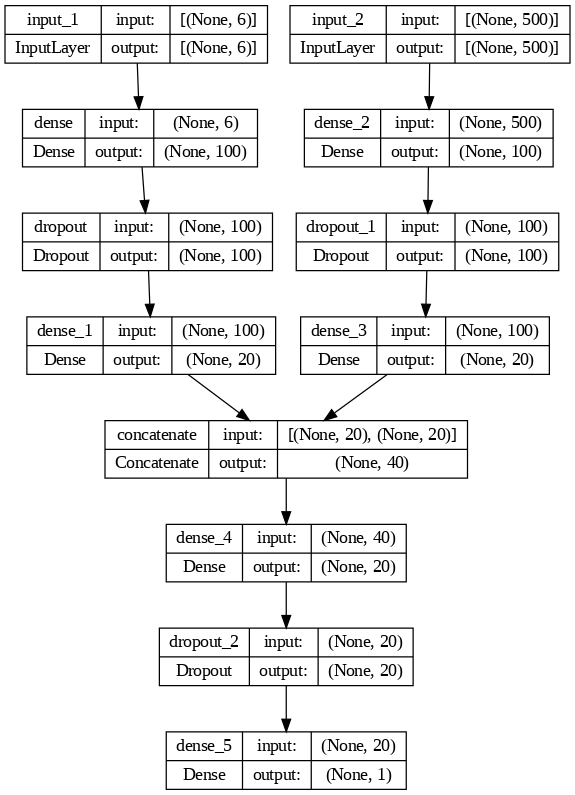

In [6]:
input1 = Input((X_train.shape[1],))
x1 = Dense(100, activation="relu")(input1)
x1 = Dropout(0.2)(x1)
x1 = Dense(20, activation="relu")(x1)

input2 = Input((X_Bow_train.shape[1],))
x2 = Dense(100, activation="relu")(input2)
x2 = Dropout(0.2)(x2)
x2 = Dense(20, activation="relu")(x2)

x = concatenate([x1, x2])                 # Объединение
x = Dense(20, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.2)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

model_final = Model((input1, input2), x)
utils.plot_model(model_final, show_shapes=True, dpi=90)


Min Val MAE = 0.0932. Epoch: 22.


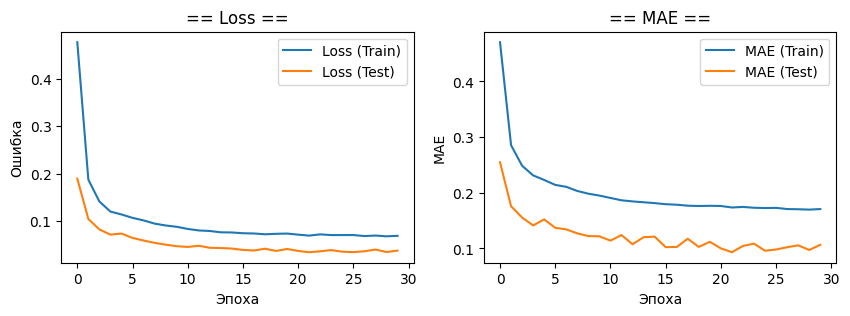

In [7]:
model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

model_checkpoint = ModelCheckpoint('model.keras',
                                    monitor='mae',
                                    save_best_only=True,
                                    verbose=0)

history = model_final.fit([X_train, X_Bow_train], Y_train,
                           batch_size=256,
                           epochs=30,
                           validation_data=([X_val, X_Bow_val], Y_val),
                           verbose=0,
                           callbacks=[model_checkpoint])

model_plot(history)

In [8]:
model = load_model('model.keras')
y_val_pred = model.predict([X_val, X_Bow_val])
y_val_pred = scaler_Y.inverse_transform(y_val_pred)

y_val = scaler_Y.inverse_transform(Y_val)
print('Средняя абсолютная ошибка:', mean_absolute_error(y_val_pred, y_val))

328/328 [==============================] - 0s 1ms/step
Средняя абсолютная ошибка: 2.420764290343249


In [9]:
data = list(zip(y_val_pred, y_val, abs(y_val_pred - y_val)))
data = [[item.item() for item in sublist] for sublist in data]
data = pd.DataFrame(data, columns=['y_val_pred', 'y_val', 'abs_error'])
data[150:155]

,y_val_pred,y_val,abs_error
150,141.917542,142.0,0.082458
151,171.300278,171.0,0.300278
152,133.425873,135.0,1.574127
153,149.398712,150.0,0.601288
154,107.903374,101.0,6.903374


In [10]:
# Абсолютная ошибка
data.describe()['abs_error'].loc[['min', 'mean', 'max']]

min       0.000320
mean      2.420764
max     178.810181
Name: abs_error, dtype: float64

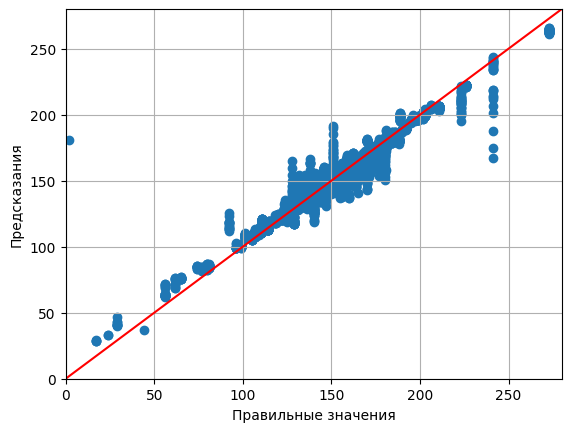

In [11]:
plt.scatter(y_val, y_val_pred)
plt.xlim(0, 280)
plt.ylim(0, 280)
plt.plot(plt.xlim(), plt.ylim(), 'r') # Отрисовка диагональной линии
plt.xlabel('Правильные значения')
plt.ylabel('Предсказания')
plt.grid()
plt.show()